In [1]:
import scipy
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from scipy.linalg import svd
from skimage import exposure
import cv2

In [2]:
two_lights = scipy.io.loadmat("illuminant_separation/data/images/two_lights/book.mat")
reflectance_illum_camera = scipy.io.loadmat("illuminant_separation/data/reflectance_illum_camera.mat")

In [4]:
def plot_spectrum(spectrum, title, spectrum_type):
    # wavelengths from 380 - 780 nm
    wavelengths = np.linspace(380, 780, 101)
    plt.figure(figsize=(8, 4))
    plt.plot(wavelengths, spectrum, 'b-', linewidth=2)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.xlabel('Wavelength (nm)')
    if spectrum_type == 'reflectance':
        plt.ylabel('Reflectance')
        plt.ylim([0, 1])
    else:
        plt.ylabel('Illumination')
        plt.ylim([0, plt.ylim()[1]])

    plt.title(title)
    plt.xticks(np.arange(380, 781, 50))

    # Add vertical lines for RGB peak sensitivities (approximately)
    rgb_peaks = [450, 550, 600]  # Blue, Green, Red approximate peaks
    colors = ['blue', 'green', 'red']
    for peak, color in zip(rgb_peaks, colors):
        plt.axvline(x=peak, color=color, linestyle=':', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_camera_response(camera_response):
    assert camera_response.shape[0]== 3
    R,G,B = camera_response

    wavelengths = np.linspace(380, 780, R.shape[0])
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, R, 'r-', linewidth=2)
    plt.plot(wavelengths, G, 'g-', linewidth=2)
    plt.plot(wavelengths, B, 'b-', linewidth=2)

    plt.legend(['Red', 'Green', 'Blue'], loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Wavelength (nm)')
    plt.title("Camera Response Function")
    plt.xticks(np.arange(380, 781, 50))

    # Add vertical lines for RGB peak sensitivities (approximately)
    rgb_peaks = [450, 550, 600]  # Blue, Green, Red approximate peaks
    colors = ['blue', 'green', 'red']
    for peak, color in zip(rgb_peaks, colors):
        plt.axvline(x=peak, color=color, linestyle=':', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
def to_8bit(img): 
    min_i = img.min()
    max_i = img.max()
    img = (img - min_i)/(max_i - min_i)
    return (255 * img).astype(np.uint8)

def contrast_stretch(img_array: np.array, amin: float=0.0, amax: float=255.0, lower_percentile: int = 2, higher_percentile: int = 98):
    num_channels = 3 if len(img_array.shape) == 3 else 1
    img_array = img_array.astype(np.float32)

    if num_channels == 1:
        ahigh = img_array.max()
        alow = img_array.min()
        if amax == ahigh and amin == alow:
            ahigh = np.percentile(img_array, higher_percentile) 
            alow = np.percentile(img_array, lower_percentile)
        slope = (amax - amin)/(ahigh - alow)
        img_array = amin + (slope * (img_array - alow))  
    else:
        # per channel contrast stretching
        for i in range(num_channels):
            ahigh = img_array[:, :, i].max()
            alow = img_array[:, :, i].min()
            if amax == ahigh and amin == alow:
                ahigh = np.percentile(img_array[:, :, i], higher_percentile) 
                alow = np.percentile(img_array[:, :, i], lower_percentile)
            slope = (amax - amin)/(ahigh - alow)
            img_array[:,:,i] = amin + (slope * (img_array[:,:,i] - alow))  

    img_array = np.clip(img_array, 0, 255)
    
    return img_array.astype(np.uint8)

def hist_eq(img):
    image_eq = exposure.equalize_hist(img)
    return image_eq 

def display_img(img, hist_equalize=False):
    if hist_equalize:
        image_eq = hist_eq(img)
        image_8bit = (255 * image_eq).astype(np.uint8)
    else:
        image_8bit = to_8bit(img)
    return Image.fromarray(image_8bit)


In [5]:
# N x M : N samples for spectra and M samples in database
illumination_spectra = reflectance_illum_camera['L']
print(illumination_spectra.shape)
reflectance_spectra = reflectance_illum_camera['R']
print(reflectance_spectra.shape)
camera_response_spectra = reflectance_illum_camera['C']
print(camera_response_spectra.shape)

(101, 158)
(101, 1269)
(101, 3)


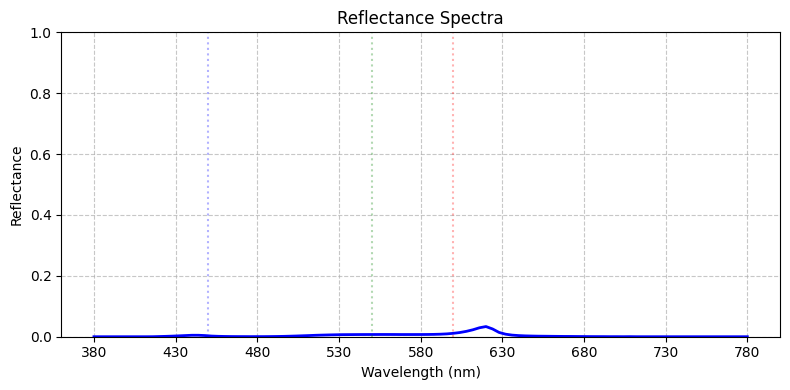

In [6]:
plot_spectrum(illumination_spectra.T[2], "Reflectance Spectra", "reflectance")

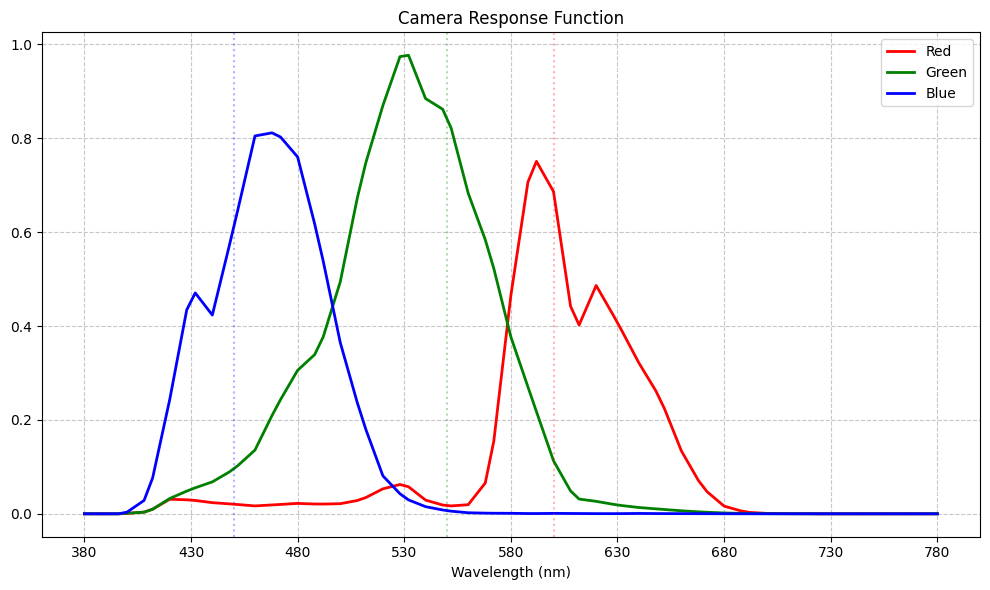

In [7]:
plot_camera_response(camera_response_spectra.T)

In [8]:
illumination_spectra.T.shape

(158, 101)

In [9]:
# get reflectance and illumination bases B_r, B_l

def compute_basis(spectra, method, camera_response, num_components=3):
    """
    compute the basis for the given spectra
    Params:
    spectra: spectra array of shape (N, lambdas) 
    num_components: number of components for reduced space
    method: weighted pca or pca (wpca, pca)
    camera_response: if using weighted pca, then crf is the weight (3,lambdas)
    """
    assert method in ["wpca", "pca"]
    if method == 'wpca':
        assert camera_response is not None
        assert camera_response.shape[0] == 3

    spectra = spectra - spectra.mean(axis=0)
    if method == 'pca':
        # mean centered
        U,S,Vt = np.linalg.svd(spectra, full_matrices=False)
        Basis = Vt.T[:, :num_components]

    else:
        # weighted PCA method from the paper
        # TODO: in the paper, there is no mention of spectra being centered
        # so check if this gives us the same result, probably should
        R = []
        for i in range(3):
            R_scaled = spectra @ np.diag(camera_response[i])
            _, _, Vt = np.linalg.svd(R_scaled, full_matrices=False)
            R.append(Vt.T[:, :1])

        R = np.hstack(R)
        Basis, _ = np.linalg.qr(R)
        
    return Basis
        
        


In [10]:
camera_response_spectra.shape

(101, 3)

In [11]:
def compute_E(B_r, B_l, crf):
    # B_r: (N, M1) reflectance basis
    # B_l: (N, M2) illumination basis
    # crf: (N, 3) camera response spectra
    assert B_r.shape[-1] == B_l.shape[-1], "M1 != M2"
    M = B_r.shape[-1]
    E = np.empty((3, M, M)) # 3 channels x M1 x M2
    for i in range(3):
        E[i, :, :] = B_r.T @ np.diag(crf[:, i]) @ B_l
    return E

def compute_reflectance(B_r, B_l, E, crf, pf):
    # function to get reflectance coefficients
    #first compute flash spectra

    flash_light = 0.025 * np.ones(101)
    f = B_l.T @ flash_light
    f = f / np.linalg.norm(f)

    H,W,C = pf.shape
    Amat = np.zeros((3, 3))
    Amat[:, 0] = E[0, :, :] @ f  
    Amat[:, 1] = E[1, :, :] @ f 
    Amat[:, 2] = E[2, :, :] @ f 
    # Reshape diff_img and im_nf to 3x(N), where N is the number of pixels
    diff_img_vec = pf.reshape(-1, 3).T

    # Get the alpha image using matrix division
    alpha_img = np.linalg.solve(Amat.T, diff_img_vec)

    alpha_img = alpha_img.T.reshape(H, W, 3)

    # Compute the norm of alpha for each pixel
    alpha_norm = np.linalg.norm(alpha_img, axis=2, keepdims=True) + 1e-10

    # Compute the normalized alpha image
    alpha_norm_img = alpha_img / alpha_norm
    
    # get reflectance image by integrating with the Basis and camera response function
    reflectance_img = ((alpha_norm_img.reshape(-1, 3) @ B_r.T) @ crf).reshape(H, W, C)
    return {'reflectance_img': reflectance_img, 'alpha_img': alpha_img, 'alpha_norm_img': alpha_norm_img, 'alpha_norm': alpha_norm}





In [116]:
B_r = compute_basis(reflectance_spectra.T, "wpca", camera_response_spectra.T)
B_l = compute_basis(illumination_spectra.T, "wpca", camera_response_spectra.T)
E = compute_E(B_r=B_r, B_l=B_l, crf=camera_response_spectra)
im_f = two_lights['im_f']
im_nf = two_lights['im_nf']
mask = two_lights['mask']
im_pf = ( im_f - im_nf) * mask[:,:, np.newaxis]
reflectance_dict = compute_reflectance(B_r=B_r, B_l=B_l, E=E, crf=camera_response_spectra, pf=im_pf)


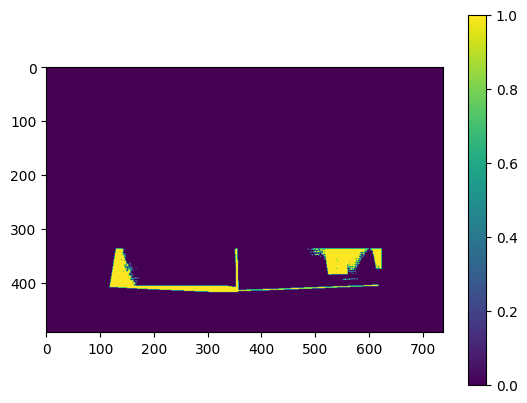

In [52]:
plt.imshow(two_lights['shadows'])
plt.colorbar()

In [58]:
def shadowRM(im_nf, im_f, mask, alpha_img, shadow_mask):
    k = 50
    H,W,C = im_nf.shape
    im_nf = im_nf.reshape(-1, 3)
    im_f = im_f.reshape(-1, 3)

    alpha_img = alpha_img.reshape(-1, 3)

    W1 = alpha_img.copy()
    id_s = np.where(shadow_mask == 1)[0]

    nf_gray = cv2.cvtColor(to_8bit(im_nf.reshape(H, W, C)), cv2.COLOR_RGB2GRAY)
    f_gray = cv2.cvtColor(to_8bit(im_f.reshape(H, W, C)), cv2.COLOR_RGB2GRAY)
    
    nf_mag = np.sqrt(cv2.Sobel(nf_gray, cv2.CV_64F, 1, 0, ksize=3)**2 + cv2.Sobel(nf_gray, cv2.CV_64F, 0, 1, ksize=3)**2)
    f_mag = np.sqrt(cv2.Sobel(f_gray, cv2.CV_64F, 1, 0, ksize=3)**2 + cv2.Sobel(f_gray, cv2.CV_64F, 0, 1, ksize=3)**2)

    # filter out penumbra pixels
    w_size = 3
    h_win_size = 1
    row_idx, col_idx = np.unravel_index(id_s, (H, W))
    
    return nf_mag, f_mag

    
out = shadowRM(im_nf, im_f, mask, reflectance_dict['alpha_img'], two_lights['shadows'])
    
    


    

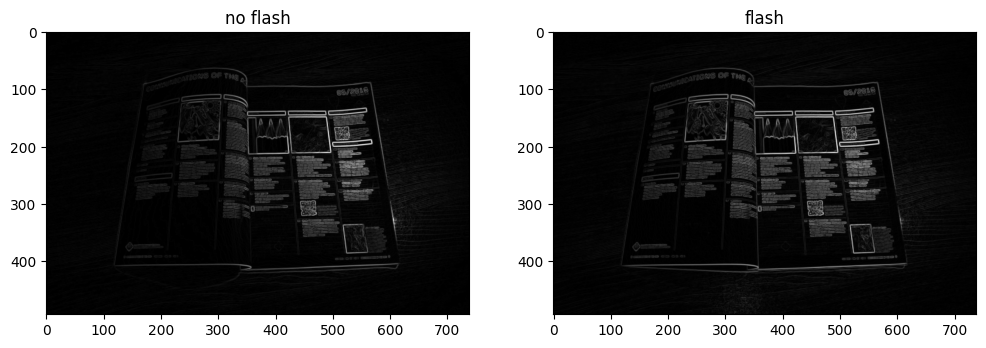

In [69]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(out[0], cmap='gray')
plt.title("no flash")
plt.subplot(1, 2, 2)
plt.imshow(out[1], cmap='gray')
plt.title("flash")
plt.show()

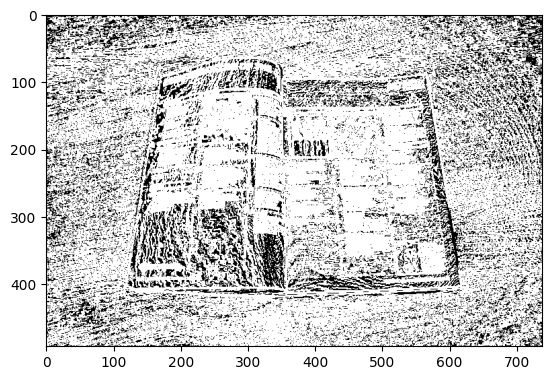

In [134]:
plt.imshow((out[1] - out[0]) > 0.01, cmap='gray')

/Users/ayank/.pyenv/versions/3.10.11/envs/pgpt/lib/python3.10/site-packages/skimage/_shared/utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


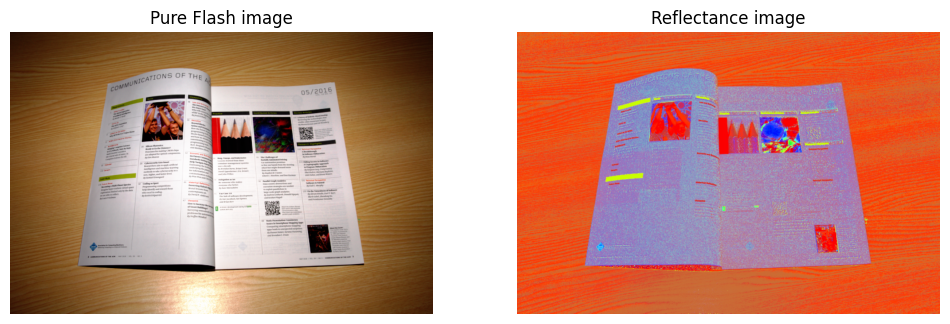

In [117]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

axes[0].imshow(to_8bit(hist_eq(im_pf)))
axes[0].set_title("Pure Flash image")
axes[0].axis('off')
axes[1].imshow(to_8bit(hist_eq(reflectance_dict['reflectance_img'])))
axes[1].set_title("Reflectance image")
axes[1].axis('off')
plt.show()

In [81]:
import skimage

/Users/ayank/.pyenv/versions/3.10.11/envs/pgpt/lib/python3.10/site-packages/skimage/_shared/utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


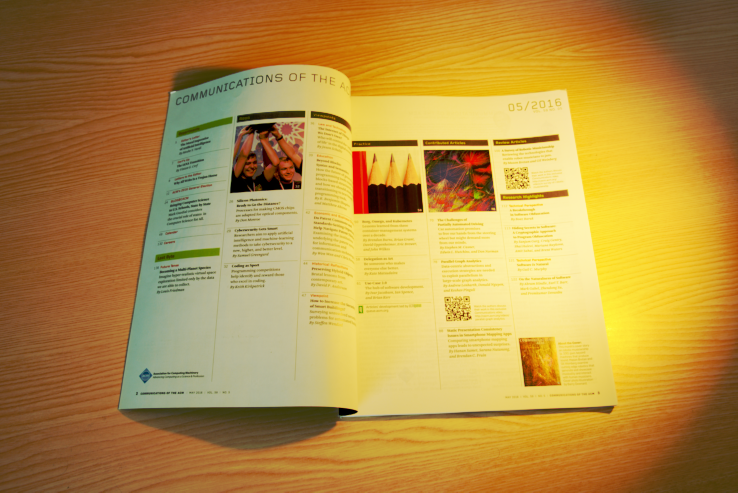

In [131]:
display_img(im_nf, True)

In [32]:
from sklearn.linear_model import Ridge

In [118]:
def compute_illumination(B_l, E, crf, alpha_norm_img, nf):
    alpha_norm_vec = alpha_norm_img.reshape(-1, 3) 
    nf_img_vec = nf.reshape(-1, 3)

    H, W = nf.shape[0], nf.shape[1]
    N = nf_img_vec.shape[0]
    beta_p = np.zeros((N, 3))
    for i in range(N):
        # ridge_reg = Ridge(alpha=1e-5, fit_intercept=False)
        _B_i = (alpha_norm_vec[i] @ E)
        _I_i = nf_img_vec[i]
        # ridge_reg.fit(_B_i, _I_i)
        # beta_p[i, :] = ridge_reg.coef_.flatten()
        _beta_p = np.linalg.solve(_B_i, _I_i)
        beta_p[i, :] = _beta_p

    beta_img = beta_p.reshape(H, W, 3)
    beta_norm = np.linalg.norm(beta_img, axis=2, keepdims=True) + 1e-10
    gamma = beta_img / beta_norm
    illumination_img = ((gamma.reshape(-1, 3) @ B_l.T) @ crf).reshape(H, W, 3)
    return {'beta_img': beta_img, 'beta_norm': beta_norm, 'gamma': gamma, 'illumination_img': illumination_img}
    


In [119]:
illumination_dict = compute_illumination(B_l=B_l, E=E, crf=camera_response_spectra, alpha_norm_img=reflectance_dict['alpha_norm_img'], nf=im_nf)

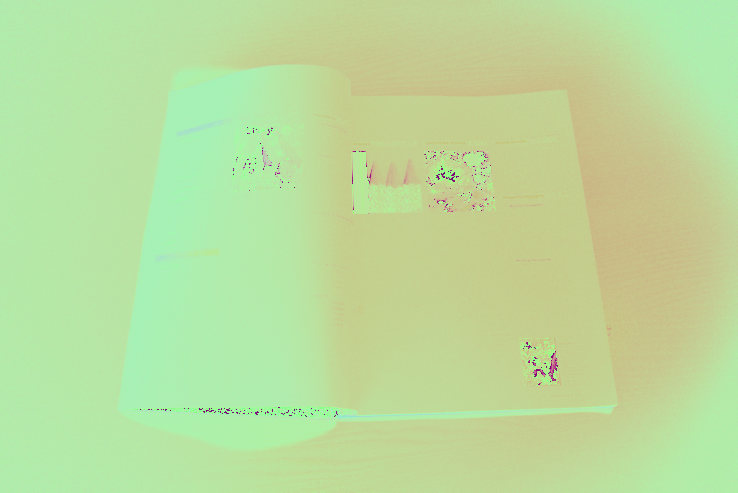

In [120]:
display_img(illumination_dict['illumination_img'])

In [121]:


def estimate_two_light_coeffs(gamma, mask, inlier_angle, cfactor, ransac_iter):
    # estimate 2 light coefficient
    M = 2
    pts = gamma[(mask>0), :]
    # pts = gamma_smooth[(mask > 0), :]
    inliers = pts.shape[0]//2
    max_inlier = 0
    n0_max = None

    for _ in range(iter):
        # Randomly sample two points
        x0 = np.random.choice(pts.shape[0], 2, replace=False)
        n0 = np.cross(pts[x0[0], :],  pts[x0[1], :])
        n0 = n0 / np.linalg.norm(n0)

        # count inliers based on angle threshold
        angles = np.abs(np.arcsin(np.dot(n0, pts.T)))
        in_count = np.sum(angles <= inlier_angle)

        if in_count > max_inlier:
            max_inlier = in_count
            n0_max = n0
    
    angles = np.abs(np.arcsin(np.dot(n0_max, pts.T)))
    in_idx = np.where(angles <= inlier_angle)[0]
    
    # create subspace from inlier points
    U, S, Vt = np.linalg.svd(pts[in_idx].T, full_matrices=False)
    n0 = U[:, -1] # Normal vector
    nx = U[:, :-1] # Basis vector
    
    # estimate light coefficients
    theta = np.linspace(0, 2*np.pi, 360)
    circ = np.dot(nx, np.vstack([np.cos(theta), np.sin(theta)]))  

    indices = np.argmax(np.dot(circ.T, pts.T), axis=0)
    
    hist, bins = np.histogram(indices, bins=len(theta))
    cutoff = cfactor * np.sum(hist) / len(theta)
    dominant_angles = theta[hist > cutoff]

    theta1 = dominant_angles[0]
    theta2 = dominant_angles[-1]

    illum1 = np.dot(nx, [np.cos(theta1), np.sin(theta1)])
    illum2 = np.dot(nx, [np.cos(theta2), np.sin(theta2)])

    return illum1, illum2
    
    

In [122]:
inlier_angle = .3*np.pi/180 # 0.3 degrees in radians
iter = 1000
cfactor = 0.1

illum1, illum2 = estimate_two_light_coeffs(gamma=illumination_dict['gamma'], mask=mask, inlier_angle=inlier_angle, cfactor=cfactor, ransac_iter=iter)

In [123]:
def separate_two_light(alpha_img, alpha_norm, beta_norm, im_nf):

    alpha_vec = alpha_img.reshape(-1, 3)
    nf_img_vec = im_nf.reshape(-1, 3)
    norm_reciprocal = (beta_norm / alpha_norm).reshape(-1)

    mR1 = (alpha_vec @ E[0, :, :] @ illum1) * (norm_reciprocal)    
    mR2 = (alpha_vec @ E[0, :, :] @ illum2) * (norm_reciprocal)    

    mG1 = (alpha_vec @ E[1, :, :] @ illum1) * (norm_reciprocal)    
    mG2 = (alpha_vec @ E[1, :, :] @ illum2) * (norm_reciprocal)    

    mB1 = (alpha_vec @ E[2, :, :] @ illum1) * (norm_reciprocal)    
    mB2 = (alpha_vec @ E[2, :, :] @ illum2) * (norm_reciprocal) 
    
    # Estimate relative shading
    z_ps = []
    for p in range(alpha_vec.shape[0]):
        Amat_ = np.array([
            [mR1[p], mR2[p]],
            [mG1[p], mG2[p]], 
            [mB1[p], mB2[p]]
            ])
        bvec_ = nf_img_vec[p]
        z_p, _, _, _ = np.linalg.lstsq(Amat_, bvec_, rcond=None)
        z_ps.append(z_p)

    z_ps = np.array(z_ps) # (H*W,2) per pixel shading
    
    # Now recompute light coefficients
    _const1 = (z_ps[:, 0] * (norm_reciprocal))
    _const2 = (z_ps[:, 1] * (norm_reciprocal))
    
    mR1 = (alpha_vec @ E[0, :, :] ) * np.tile(_const1, (3, 1)).T
    mR2 = (alpha_vec @ E[0, :, :] ) * np.tile(_const2, (3, 1)).T  

    mG1 = (alpha_vec @ E[1, :, :] ) * np.tile(_const1, (3, 1)).T 
    mG2 = (alpha_vec @ E[1, :, :] ) * np.tile(_const2, (3, 1)).T 

    mB1 = (alpha_vec @ E[2, :, :] ) * np.tile(_const1, (3, 1)).T   
    mB2 = (alpha_vec @ E[2, :, :] ) * np.tile(_const2, (3, 1)).T   
    
    block_matrix = np.vstack([
        np.hstack([mR1, mR2]),  # MR1' MR2'
        np.hstack([mG1, mG2]),  # MG1' MG2'
        np.hstack([mB1, mB2])   # MB1' MB2'
    ]) 
    b_full = nf_img_vec.reshape(-1)
    out, _, _, _=  np.linalg.lstsq(block_matrix, b_full, rcond=None)

    illum_re_1 = out[:3]
    illum_re_2 = out[3:]    
    
    illum_re_1 = illum_re_1 / np.linalg.norm(illum_re_1)
    illum_re_2 = illum_re_2 / np.linalg.norm(illum_re_2)    
        
    return {'illum_re_1': illum_re_1, 'illum_re_2': illum_re_2, 'rel_shading': z_ps}
        

In [124]:
separation_dict = separate_two_light(alpha_img=reflectance_dict['alpha_img'], alpha_norm=reflectance_dict['alpha_norm'], beta_norm=illumination_dict['beta_norm'], im_nf=im_nf)

In [125]:
def create_single_illuminant_img(E, alpha_img, alpha_norm, illum_coefficient, beta_norm, rel_shading):
    assert len(rel_shading.shape) == 1
    img = []
    norm_reciprocal = (beta_norm / alpha_norm).reshape(-1)
    _const = (rel_shading * (norm_reciprocal))
    H, W = alpha_img.shape[:2]

    for k in range(3):
        chan_img = (alpha_img.reshape(-1, 3) @ E[k,:,:] @ illum_coefficient) * _const
        img.append(chan_img.reshape(H, W))
    
    img = np.stack(img, axis=-1)
    return img

In [126]:
est_img_1 = create_single_illuminant_img(
    E=E, 
    alpha_img=reflectance_dict['alpha_img'], 
    alpha_norm=reflectance_dict['alpha_norm'], 
    illum_coefficient=separation_dict['illum_re_1'], 
    beta_norm=illumination_dict['beta_norm'], 
    rel_shading=separation_dict['rel_shading'][:, 0])
est_img_2 = create_single_illuminant_img(
    E=E, 
    alpha_img=reflectance_dict['alpha_img'], 
    alpha_norm=reflectance_dict['alpha_norm'], 
    illum_coefficient=separation_dict['illum_re_2'],
    beta_norm=illumination_dict['beta_norm'], 
    rel_shading=separation_dict['rel_shading'][:, 1])


/Users/ayank/.pyenv/versions/3.10.11/envs/pgpt/lib/python3.10/site-packages/skimage/_shared/utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


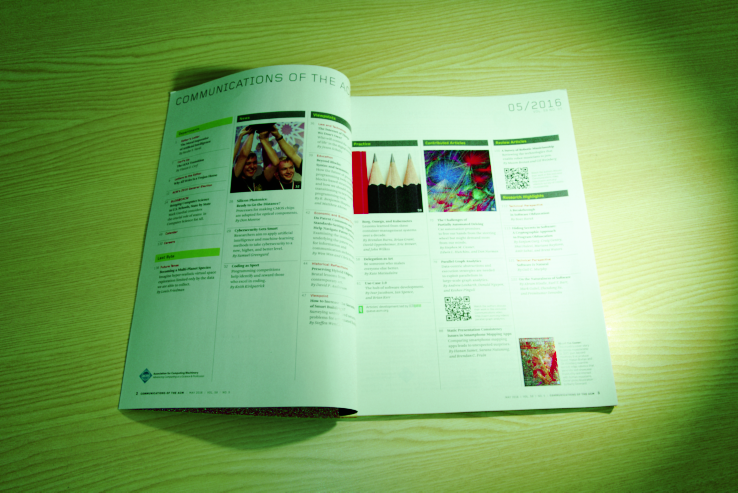

In [130]:
display_img(est_img_1, True)

/Users/ayank/.pyenv/versions/3.10.11/envs/pgpt/lib/python3.10/site-packages/skimage/_shared/utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


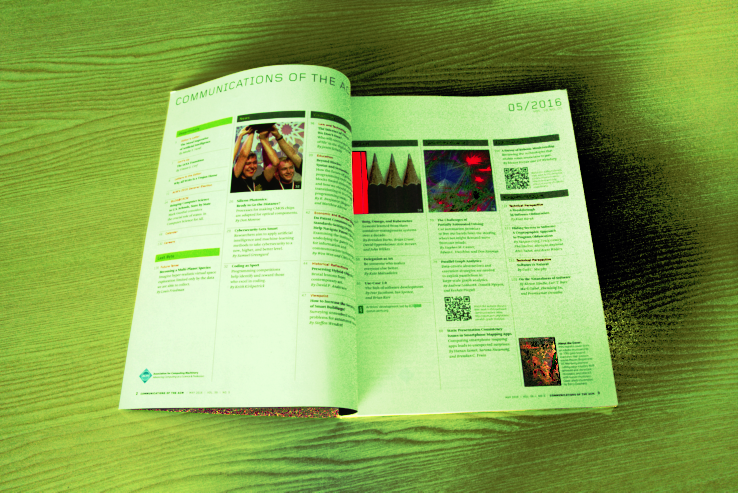

In [129]:
display_img(est_img_2, True)